In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.momentum import StochasticOscillator
from ta.momentum import RSIIndicator

import random

import gym
from gym import spaces

pd.set_option('display.precision', 3)  # Set the precision for floating-point numbers
np.set_printoptions(precision=3)  # Set the precision for floating-point numbers

In [154]:
#Download stock data
df = pd.read_csv("C:/Users/ramif/OneDrive/Desktop/RL/Final_project/AAPL.csv")

In [155]:
#Set Date time formatting
df['Date'] = pd.to_datetime(df['Date'])

#Filter
start_date = '2010-11-10'
end_date = '2023-11-10'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Calculate Stochastic Momentum Index (SMI)
stoch = StochasticOscillator(close  = df['Adj Close'], high = df['High'], low  = df['Low'], window=14, smooth_window=3)
df['smi'] = stoch.stoch_signal()

# Calculate Relative Strength Index (RSI)
rsi = RSIIndicator(df['Adj Close'], window=14)
df['rsi'] = rsi.rsi()

# Drop rows with any NaN values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [156]:
#Bucket the data

# Bucket the 'rsi' column into 10 equally sized buckets and return the bins
rsi_buckets, rsi_bins = pd.qcut(df['rsi'], q=10, retbins=True, labels=False)

# Bucket the 'smi' column into 10 equally sized buckets and return the bins
smi_buckets, smi_bins = pd.qcut(df['smi'], q=10, retbins=True, labels=False)

# Print the resulting bins and their ranges
print("RSI Bins and Ranges:")
for i, bin_range in enumerate(zip(rsi_bins[:-1], rsi_bins[1:])):
    print(f"Bucket {i + 1}: Range {bin_range}")

print("\nSMI Bins and Ranges:")
for i, bin_range in enumerate(zip(smi_bins[:-1], smi_bins[1:])):
    print(f"Bucket {i + 1}: Range {bin_range}")

# Bucket the 'rsi' column into 10 equally sized buckets and add the 'rsi_bucket' column
df['rsi_bucket'] = pd.qcut(df['rsi'], q=10, labels=False)

# Bucket the 'smi' column into 10 equally sized buckets and add the 'smi_bucket' column
df['smi_bucket'] = pd.qcut(df['smi'], q=10, labels=False)

df = df.dropna()
df

RSI Bins and Ranges:
Bucket 1: Range (21.030193700555927, 38.16705711289119)
Bucket 2: Range (38.16705711289119, 43.27505617190777)
Bucket 3: Range (43.27505617190777, 47.75935408580875)
Bucket 4: Range (47.75935408580875, 51.77853093327352)
Bucket 5: Range (51.77853093327352, 55.30456246772176)
Bucket 6: Range (55.30456246772176, 59.044207590911824)
Bucket 7: Range (59.044207590911824, 62.73653768480778)
Bucket 8: Range (62.73653768480778, 66.97647301510057)
Bucket 9: Range (66.97647301510057, 72.54070540022269)
Bucket 10: Range (72.54070540022269, 90.69590856056443)

SMI Bins and Ranges:
Bucket 1: Range (-518.6255557917461, -143.19797061549116)
Bucket 2: Range (-143.19797061549116, -98.73407397084632)
Bucket 3: Range (-98.73407397084632, -71.13389232529867)
Bucket 4: Range (-71.13389232529867, -44.80396934223128)
Bucket 5: Range (-44.80396934223128, -18.883348815477916)
Bucket 6: Range (-18.883348815477916, 3.709652359937253)
Bucket 7: Range (3.709652359937253, 20.685964472740736)
Bu

Date     Open     High      Low    Close  Adj Close     Volume  \
0    2010-12-02   11.340   11.393   11.246   11.363      9.632  462837200   
1    2010-12-03   11.322   11.380   11.298   11.337      9.610  342092800   
2    2010-12-06   11.380   11.512   11.372   11.434      9.692  448481600   
3    2010-12-07   11.564   11.571   11.361   11.365      9.634  391454000   
4    2010-12-08   11.415   11.465   11.325   11.465      9.718  321935600   
...         ...      ...      ...      ...      ...        ...        ...   
3253 2023-11-06  176.380  179.430  176.210  179.230    178.994   63841300   
3254 2023-11-07  179.180  182.440  178.970  181.820    181.581   70530000   
3255 2023-11-08  182.350  183.450  181.590  182.890    182.649   49340300   
3256 2023-11-09  182.960  184.120  181.810  182.410    182.170   53763500   
3257 2023-11-10  183.970  186.570  183.530  186.400    186.400   66133400   

          smi     rsi  rsi_bucket  smi_bucket  
0    -145.732  56.205           5           0  
1    -136.780  55.050           4           1  
2    -124.833  58.552           5           1  
3    -116.388  55.235           4           1  
4    -127.653  58.858           5           1  
...       ...     ...         ...         ...  
3253   89.375  59.171           6           9  
3254   92.001  63.211           7           9  
3255   95.735  64.763           7           9  
3256   93.268  63.470           7           9  
3257   94.705  69.295           8           9  

[3258 rows x 11 columns]

In [157]:
########################Add states to the dataframe
df['state'] = df.apply(lambda row: (row['rsi_bucket'], row['smi_bucket']), axis=1)

#Add next state column
df['next_state'] = df['state'].shift(-1)

#Add column for reward if buy
df['buy_reward'] = df['Adj Close'].pct_change()

#Add column for reward if sell
df['sell_reward'] = 0

#Drop rows with empty values
df = df.dropna()

df.reset_index(drop=True, inplace=True)

df

Date     Open     High      Low    Close  Adj Close     Volume  \
0    2010-12-03   11.322   11.380   11.298   11.337      9.610  342092800   
1    2010-12-06   11.380   11.512   11.372   11.434      9.692  448481600   
2    2010-12-07   11.564   11.571   11.361   11.365      9.634  391454000   
3    2010-12-08   11.415   11.465   11.325   11.465      9.718  321935600   
4    2010-12-09   11.505   11.518   11.394   11.420      9.681  294151200   
...         ...      ...      ...      ...      ...        ...        ...   
3251 2023-11-03  174.240  176.820  173.350  176.650    176.418   79763700   
3252 2023-11-06  176.380  179.430  176.210  179.230    178.994   63841300   
3253 2023-11-07  179.180  182.440  178.970  181.820    181.581   70530000   
3254 2023-11-08  182.350  183.450  181.590  182.890    182.649   49340300   
3255 2023-11-09  182.960  184.120  181.810  182.410    182.170   53763500   

          smi     rsi  rsi_bucket  smi_bucket   state next_state  buy_reward  \
0    -136.780  55.050           4           1  (4, 1)     (5, 1)      -0.002   
1    -124.833  58.552           5           1  (5, 1)     (4, 1)       0.009   
2    -116.388  55.235           4           1  (4, 1)     (5, 1)      -0.006   
3    -127.653  58.858           5           1  (5, 1)     (5, 0)       0.009   
4    -152.646  56.653           5           0  (5, 0)     (5, 0)      -0.004   
...       ...     ...         ...         ...     ...        ...         ...   
3251   73.643  54.555           4           9  (4, 9)     (6, 9)      -0.005   
3252   89.375  59.171           6           9  (6, 9)     (7, 9)       0.015   
3253   92.001  63.211           7           9  (7, 9)     (7, 9)       0.014   
3254   95.735  64.763           7           9  (7, 9)     (7, 9)       0.006   
3255   93.268  63.470           7           9  (7, 9)     (8, 9)      -0.003   

      sell_reward  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
3251            0  
3252            0  
3253            0  
3254            0  
3255            0  

[3256 rows x 15 columns]

In [158]:
#shift the values appropriately to account for time lag
df['buy_reward'] = df['buy_reward'].shift(-1)
df

C:\Users\ramif\AppData\Local\Temp\ipykernel_8760\51310214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_reward'] = df['buy_reward'].shift(-1)


Date     Open     High      Low    Close  Adj Close     Volume  \
0    2010-12-03   11.322   11.380   11.298   11.337      9.610  342092800   
1    2010-12-06   11.380   11.512   11.372   11.434      9.692  448481600   
2    2010-12-07   11.564   11.571   11.361   11.365      9.634  391454000   
3    2010-12-08   11.415   11.465   11.325   11.465      9.718  321935600   
4    2010-12-09   11.505   11.518   11.394   11.420      9.681  294151200   
...         ...      ...      ...      ...      ...        ...        ...   
3251 2023-11-03  174.240  176.820  173.350  176.650    176.418   79763700   
3252 2023-11-06  176.380  179.430  176.210  179.230    178.994   63841300   
3253 2023-11-07  179.180  182.440  178.970  181.820    181.581   70530000   
3254 2023-11-08  182.350  183.450  181.590  182.890    182.649   49340300   
3255 2023-11-09  182.960  184.120  181.810  182.410    182.170   53763500   

          smi     rsi  rsi_bucket  smi_bucket   state next_state  buy_reward  \
0    -136.780  55.050           4           1  (4, 1)     (5, 1)       0.009   
1    -124.833  58.552           5           1  (5, 1)     (4, 1)      -0.006   
2    -116.388  55.235           4           1  (4, 1)     (5, 1)       0.009   
3    -127.653  58.858           5           1  (5, 1)     (5, 0)      -0.004   
4    -152.646  56.653           5           0  (5, 0)     (5, 0)       0.003   
...       ...     ...         ...         ...     ...        ...         ...   
3251   73.643  54.555           4           9  (4, 9)     (6, 9)       0.015   
3252   89.375  59.171           6           9  (6, 9)     (7, 9)       0.014   
3253   92.001  63.211           7           9  (7, 9)     (7, 9)       0.006   
3254   95.735  64.763           7           9  (7, 9)     (7, 9)      -0.003   
3255   93.268  63.470           7           9  (7, 9)     (8, 9)         NaN   

      sell_reward  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
3251            0  
3252            0  
3253            0  
3254            0  
3255            0  

[3256 rows x 15 columns]

In [159]:
"""
#Note:
# Filter test data (11-11-2022 to 11-10-2023)
test_start_date = '2022-11-11'
test_end_date = '2023-11-10'
df_test = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

# Filter train data (11-10-2010 to 11-10-2022)
train_start_date = '2010-11-10'
train_end_date = '2022-11-10'
df = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
"""

"\n#Note:\n# Filter test data (11-11-2022 to 11-10-2023)\ntest_start_date = '2022-11-11'\ntest_end_date = '2023-11-10'\ndf_test = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]\n\n# Filter train data (11-10-2010 to 11-10-2022)\ntrain_start_date = '2010-11-10'\ntrain_end_date = '2022-11-10'\ndf = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]\n"

In [160]:
class CustomTradingEnv(gym.Env):
    def __init__(self, df):
        super(CustomTradingEnv, self).__init__()

        # Define the action space (0 for buy, 1 for sell)
        self.action_space = spaces.Discrete(2)

        # Define the observation space (state)
        # Define the observation space (state)
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([10, 10], dtype=np.float32),
            shape=(2,)
        )

        # Set the DataFrame for price data
        self.df = df

        # Initialize the environment
        self.index_loc = 0
        self.state = self.df['state'].iloc[self.index_loc]
        self.done = False
        self.history = []

    def reset(self):
        # Reset the environment to its initial state
        self.index_loc = 0
        self.state = self.df['state'].iloc[self.index_loc]
        self.done = False
        self.history = []
                    
    def step(self, action):
        
        # Ensure the action is valid
        assert self.action_space.contains(action)

        # Calculate the reward based on the percentage change and balance
        self.reward = 0.0  # Initialize reward
        
        if action == 0:  # Buy
            self.reward = self.df.loc[self.index_loc, 'buy_reward']

        self.done = (self.index_loc == len(self.df) - 1)  # Episode is done when we reach the end of the DataFrame
        self.info = {}  # Additional information

        # The state is taken from the observation space
        self.state = self.df['state'].iloc[self.index_loc]

        # The current price is taken from the observation space
        self.current_price = self.df['Adj Close'].iloc[self.index_loc]        

        # Store the episode history
        self.episode_step = {
            'date': self.df['Date'].iloc[self.index_loc], # Include the date (index) from the DataFrame
            'index_loc': self.index_loc,  # Renamed 'index' to 'step'
            'state': self.state,  # Use self.state instead of state
            'action': action,
            'reward': self.reward,
            'price': self.current_price  # Use self.current_price instead of current_price
        }
        self.history.append(self.episode_step)

        # Retrieve the next state
        self.next_state = self.df['next_state'].iloc[self.index_loc]
        
        # Assign next_step
        self.index_loc = self.index_loc + 1
        self.state = self.df.loc[self.index_loc, 'state']

        # Return the updated information
        return self.index_loc, self.state, action, self.reward, self.done
env = CustomTradingEnv(df)

In [161]:
# Assuming 'state' is a column in df
unique_states = df['state'].unique()

# Setup Q table
num_actions = 2

Q = np.zeros((len(unique_states), num_actions))
Q.shape

# Transform to DataFrame
Q_df = pd.DataFrame(Q, columns=["action_0", "action_1"])
Q_df['state'] = unique_states

# Display the Q-table DataFrame
Q_df


action_0  action_1   state
0        0.0       0.0  (4, 1)
1        0.0       0.0  (5, 1)
2        0.0       0.0  (5, 0)
3        0.0       0.0  (6, 0)
4        0.0       0.0  (7, 0)
..       ...       ...     ...
92       0.0       0.0  (4, 9)
93       0.0       0.0  (8, 9)
94       0.0       0.0  (2, 9)
95       0.0       0.0  (1, 8)
96       0.0       0.0  (3, 9)

[97 rows x 3 columns]

In [162]:
# Training the Q-learning algorithm
num_episodes = 10
max_steps_per_episode = 2000  # Set your desired maximum steps per episode

for episode in range(num_episodes):
    #env.reset()  # Explicitly reset the environment at the beginning of each episode
    done = False
    env.reset()
    #index_loc = 1
    index_loc = random.randint(0,env.df.shape[0])
    state = env.df['state'].iloc[env.index_loc]     
    print(f'start_state {state}')
    steps_in_current_episode = 0  # Counter for steps in the current episode
    
    while not done and steps_in_current_episode < max_steps_per_episode:
        # Choose an action using epsilon-greedy policy
        epsilon = 0.1
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
            print(f'sample1_start_state {state}')
            print(f'action {action}')
        else:
            # Exploit: Choose the action with the maximum Q-value for the current state
            action_values = Q_df[Q_df['state'] == state][['action_0', 'action_1']].values
            print(f'sample2_start_state {state}')
            print(f'action values: {action_values[0]}')
            action = np.argmax(action_values)
            print(f'action {action}')

        # Take a step in the environment
        #return self.index_loc, self.state, action, self.reward, self.done
        index_loc, next_state, action, reward, done = env.step(action)
        print(f'r_index_loc: {index_loc}'); print(f'r_next_state {next_state}'); print(f'r_action: {action}'); print(f'r_reward: {reward}'); print(f'r_done: {done}')

        # Q LEARNING:
        alpha = 0.35  # learning rate
        gamma = 0.99  # discount factor

        # Current Q value
        action_selected_column = 'action_' + str(action)
        current_q_value = Q_df.loc[Q_df['state'] == state, action_selected_column].values[0]

        # Max_next_q_value
        max_next_q_value = Q_df.loc[Q_df['state'] == next_state, ['action_0', 'action_1']].max(axis=1).values[0]
        print(f'max_next value: {max_next_q_value}')

        # Get new Q value and update
        new_q_value = (1 - alpha) * current_q_value + alpha * (reward + gamma * max_next_q_value)
        Q_df.loc[Q_df['state'] == state, action_selected_column] = new_q_value

        steps_in_current_episode += 1
        state = next_state
        
        print(steps_in_current_episode)
        print(f"Episode {episode + 1}_{steps_in_current_episode} steps.")

start_state (4, 1)
sample2_start_state (4, 1)
action values: [0. 0.]
action 0
r_index_loc: 1
r_next_state (5, 1)
r_action: 0
r_reward: 0.008537014784603336
r_done: False
max_next value: 0.0
1
Episode 1_1 steps.
sample2_start_state (5, 1)
action values: [0. 0.]
action 0
r_index_loc: 2
r_next_state (4, 1)
r_action: 0
r_reward: -0.006059442376539548
r_done: False
max_next value: 0.0029879551746111676
2
Episode 1_2 steps.
sample1_start_state (4, 1)
action 0
r_index_loc: 3
r_next_state (5, 1)
r_action: 0
r_reward: 0.008799220144616982
r_done: False
max_next value: 0.0
3
Episode 1_3 steps.
sample2_start_state (5, 1)
action values: [-0.001  0.   ]
action 1
r_index_loc: 4
r_next_state (5, 0)
r_action: 1
r_reward: 0.0
r_done: False
max_next value: 0.0
4
Episode 1_4 steps.
sample2_start_state (5, 0)
action values: [0. 0.]
action 0
r_index_loc: 5
r_next_state (5, 0)
r_action: 0
r_reward: 0.0025023500852228153
r_done: False
max_next value: 0.0
5
Episode 1_5 steps.
sample2_start_state (5, 0)
action

In [163]:
#Get the optimal policy and save
Q_df['optimal_policy'] = np.argmax(Q_df[['action_0', 'action_1']].values, axis=1)
Q_df

action_0  action_1   state  optimal_policy
0      0.020     0.031  (4, 1)               1
1      0.028     0.031  (5, 1)               1
2      0.029     0.031  (5, 0)               1
3      0.036     0.032  (6, 0)               0
4      0.037     0.031  (7, 0)               0
..       ...       ...     ...             ...
92     0.000     0.000  (4, 9)               0
93     0.000     0.000  (8, 9)               0
94     0.000     0.000  (2, 9)               0
95     0.000     0.000  (1, 8)               0
96     0.000     0.000  (3, 9)               0

[97 rows x 4 columns]

In [164]:
#Add the optimal policy to the df
#merged_df = pd.merge(df_test, Q_df[['state', 'optimal_policy']], on='state', how='left')
merged_df = pd.merge(df, Q_df[['state', 'optimal_policy']], on='state', how='left')
merged_df = merged_df.dropna()

#Filter for the last year
test_start_date = '2022-11-11'
test_end_date = '2023-11-10'
merged_df = merged_df[(merged_df['Date'] >= test_start_date) & (merged_df['Date'] <= test_end_date)]

#add percentage change
merged_df['Adj Close_change'] = merged_df['Adj Close'].pct_change()

#add in_out status
merged_df['in_out'] = 'in'
merged_df['in_out'] = np.where(merged_df['optimal_policy'].shift(1) == 0, 'in', 'out')

merged_df = merged_df.dropna()
merged_df = merged_df.reset_index()

#add projected reward
merged_df['projected_reward'] = 0
merged_df.loc[0, 'projected_reward'] = 100.0
for i in range(1, len(merged_df)):
    if merged_df.loc[i, 'in_out'] == 'out':
        merged_df.loc[i, 'projected_reward'] = merged_df.loc[i - 1, 'projected_reward']
    elif merged_df.loc[i, 'in_out'] == 'in':
        merged_df.loc[i, 'projected_reward'] = merged_df.loc[i - 1, 'projected_reward'] * (1 + merged_df.loc[i, 'Adj Close_change']) * (1-0.0001)

merged_df.to_csv("C:/Users/ramif/OneDrive/Desktop/RL/Final_project/merged_df.csv")
merged_df[['Date', 'Adj Close', 'buy_reward', 'sell_reward', 'projected_reward', 'optimal_policy', 'in_out',]]

Date  Adj Close  buy_reward  sell_reward  projected_reward  \
0   2022-11-14    147.456       0.012            0           100.000   
1   2022-11-15    149.206      -0.008            0           101.177   
2   2022-11-16    147.963       0.013            0           100.324   
3   2022-11-17    149.882       0.004            0           101.615   
4   2022-11-18    150.449      -0.022            0           101.615   
..         ...        ...         ...          ...               ...   
243 2023-11-02    177.336      -0.005            0           119.455   
244 2023-11-03    176.418       0.015            0           119.455   
245 2023-11-06    178.994       0.014            0           121.187   
246 2023-11-07    181.581       0.006            0           122.926   
247 2023-11-08    182.649      -0.003            0           123.637   

     optimal_policy in_out  
0                 0     in  
1                 0     in  
2                 0     in  
3                 1     in  
4                 0    out  
..              ...    ...  
243               1     in  
244               0    out  
245               0     in  
246               0     in  
247               0     in  

[248 rows x 7 columns]

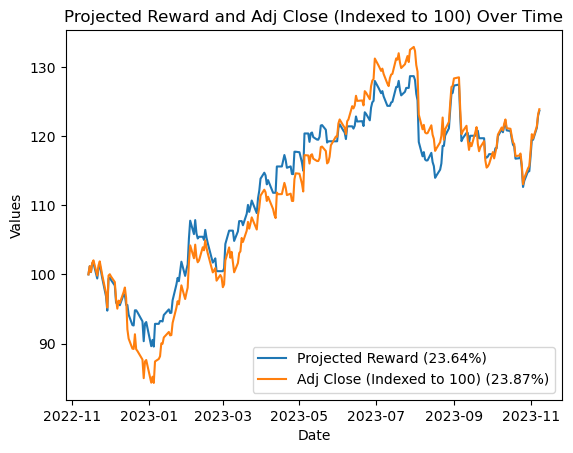

In [165]:
# Normalize 'Adj Close' to start at 100
adj_close_normalized = merged_df['Adj Close'] / merged_df['Adj Close'].iloc[0] * 100

# Calculate percentage return for each column
projected_return = (merged_df['projected_reward'].iloc[-1] / merged_df['projected_reward'].iloc[0] - 1) * 100
adj_close_return = (merged_df['Adj Close'].iloc[-1] / merged_df['Adj Close'].iloc[0] - 1) * 100

# Plot both 'projected_reward' and normalized 'Adj Close' columns with 'Date' as x-axis
plt.plot(merged_df['Date'], merged_df['projected_reward'], label=f'Projected Reward ({projected_return:.2f}%)')
plt.plot(merged_df['Date'], adj_close_normalized, label=f'Adj Close (Indexed to 100) ({adj_close_return:.2f}%)')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Projected Reward and Adj Close (Indexed to 100) Over Time')

# Add a legend
plt.legend()

# Show the plot
plt.show()